## **Alternus Vera - Analysis**
**Poorva Agarwal**

**Student ID - 013770939**

**Team - Transformers**
* The aim of the project is to develop a strategy to help identify fake news from real news and understand the influence of Context and other factors.  
* The project uses LIAR - LIAR dataset.

## **Business Problem**

Social media for news consumption is a double-edged sword.
On the one hand, its low cost, easy access, and rapid dissemination
of information lead people to seek out and consume
news from social media. On the other hand, it enables the
wide spread of “fake news”, i.e., low quality news with intentionally
false information. The extensive spread of fake
news has the potential for extremely negative impacts on
individuals and society. Therefore, fake news detection on
social media has recently become an emerging research that
is attracting tremendous attention. 

## **Context**

Some online disinformation is blatantly fake or misleading. But other stories are more subtly wrong. They might omit important details, blow small controversies out of proportion, or use legitimate news to attract people before feeding them bad information. The key here is looking for gaps in a story, or mismatches between a story’s claims and its actual source material. These might be honest mistakes — like accounts sharing satirical news without realizing it. Or they might be a deliberate attempt to fool people.In this way, context will serve as an important feature to determine fake news.

## **What did I try**

* ###  : Complex Features : Context
    - ####  Data Preparation
    - ####  Data Observation
    - ####  Data Visualization
    - ####  Featured Extraction, 
    - ####  Classification, 
    - ####  Distillation 
            - LDA 
            - LDA2Vec
            - DOC2VEC
            - Word2Vec
            - MeanEmbeddingVectorizer
            - Topic Modeling
            - Sentiment Analysis
    - ####  Extract Feature Vector
    - ####  Tag Documents using the Label
    - ####  DOC2VEC on Tagged Documents
    - ####  Concat distilled vectors with  LDA and Sentiment
    - ####  Classification
       -  Naives Bayes regression
       -  Logistic regression
       -  Linear SVM Classifier
       -  SVM Stochastic Gradient Descent on hinge loss
       -  RandomForestClassifier
    - ####  Validation
       -  K-Fold cross validation


## **Dataset Links**

https://drive.google.com/drive/folders/1GVu-WgQf8prCF3nIyUUMEXrFCOuVu16L?usp=sharing


## **Enriched Dataset Links**

https://drive.google.com/open?id=14UKG-jz0Y8cO513WtR3gZ7sw9xH26ofS


## **Mounting the Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## ignore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## **Dataset selection and observation**

In [0]:
import pandas as pd
import csv
import numpy as np

#### **Define Dataset**

In [0]:
test_filename = '/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Dataset/liar_dataset/test.tsv'
train_filename = '/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Dataset/liar_dataset/train.tsv'
valid_filename = '/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Dataset/liar_dataset/valid.tsv'

#### **Define Columns names as part of dataset**

In [0]:
colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 
            'speakerjobtitle', 'stateinfo','partyaffiliation', 
            'barelytruecounts', 'falsecounts','halftruecounts',
            'mostlytrueocounts','pantsonfirecounts','context']
headlinecolname = 'headline_text'
labelcolname = 'encoded_label'
processedheadlinecolname = 'processed_headline_text'

#### **Function to simplify label classes**

* Original --	True
* True	--	True
* Mostly-true	-- True
* Half-true	-- True
* Barely-true	-- False
* False	-- False
* Pants-fire	-- False

In [0]:
true_labels = ['original','true','mostly-true','half-true']
false_labels = ['barely-true','false','pants-fire']
def simplify_label(input_label):
    if input_label in true_labels:
        return 1
    else:
        return 0

#### **Read the input data files**

In [0]:
train_news = pd.read_csv(train_filename, sep='\t', names = colnames,error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames,error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames,error_bad_lines=False)

train_news.head()
#train_news['context'].unique()
#test_news['context'].unique()
#valid_news['context'].unique()

labelcolname = 'encoded_label'

train_news[labelcolname] = train_news.apply(lambda row: simplify_label(row['label']), axis=1)
test_news[labelcolname] = test_news.apply(lambda row: simplify_label(row['label']), axis=1)
valid_news[labelcolname] = valid_news.apply(lambda row: simplify_label(row['label']), axis=1)

# **Data Preprocessing**

We will perform the following steps:
* All stopwords are removed.
* Words that have fewer than 3 characters are removed.
* Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are stemmed — words are reduced to their root form.
* Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

In [0]:
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### **Remove Stopwords and shortwords using nltk stopwords**

In [0]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
#Remove stop words
def remove_stop_and_short_words(text):
    text = [word.lower() for word in text.split() if (word.lower() not in sw) and (len(word)>3)]
    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Spell Check

Use Google News library to build dictionary and compare the dataset

In [0]:
# model = gensim.models.KeyedVectors.load_word2vec_format('libraries/GoogleNews-vectors-negative300.bin.gz', binary=True)
# words = model.index2word

# w_rank = {}
# for i,word in enumerate(words):
#     w_rank[word] = i

# WORDS = w_rank

In [0]:
# import re
# from collections import Counter

# def words(text): return re.findall(r'\w+', text.lower())

# def P(word, N=sum(WORDS.values())): 
#     "Probability of `word`."
#     return - WORDS.get(word, 0)

# def correction(word): 
#     "Most probable spelling correction for word."
#     return max(candidates(word), key=P)

# def candidates(word): 
#     "Generate possible spelling corrections for word."
#     return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

# def known(words): 
#     "The subset of `words` that appear in the dictionary of WORDS."
#     return set(w for w in words if w in WORDS)

# def edits1(word):
#     "All edits that are one edit away from `word`."
#     letters    = 'abcdefghijklmnopqrstuvwxyz'
#     splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
#     deletes    = [L + R[1:]               for L, R in splits if R]
#     transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
#     replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
#     inserts    = [L + c + R               for L, R in splits for c in letters]
#     return set(deletes + transposes + replaces + inserts)

# def edits2(word): 
#     "All edits that are two edits away from `word`."
#     return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [0]:
# def spell_checker(text):
#     all_words = re.findall(r'\w+', text.lower()) #tokenize to words
#     spell_checked_text  = []
#     for i in range(len(all_words)):
#         if correction(all_words[i]) and (not correction(all_words[i]).isspace()):
#             spell_checked_text.append(correction(all_words[i]))
#     return " ".join(spell_checked_text)

#### **Lemmatization using Wordnet Lemmatizer and Stemming using SnowBall Stemmer**

In [0]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

#### **Remove Punctuations using nltk**

In [0]:
#method to remove punctuations from textual data
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#### **Preprocess text function**
This function makes use of all the functions above but spell check as it takes long time

In [0]:
def process_data(text):
    #print ('Input Text :: ' + text)
    text = remove_stop_and_short_words(text)
    #print('Stopwords and short words removed :: ' + text)
    text = lemmatize_stemming(text)
    #print('Lemmatized :: ' + text)
    text = remove_punctuation(text)
    #print('Punctuation removed :: ' + text)
    return text

In [0]:
print (process_data(train_news['headline_text'][0]))
process_data(train_news['headline_text'][4])

says annies list political group supports thirdtrimester abortions demand


'economic turnaround started term'

#### Preprocess text function with spell check
This function makes use of all the functions above includes spell check if we have time

In [0]:
# def process_data_spellcorrect(text):
#     #print ('Input Text :: ' + text)
#     text = remove_stop_and_short_words(text)
#     #print('Stopwords and short words removed :: ' + text)
#     text = spell_checker(text)
#     #print('Stopwords and short words removed :: ' + text)
#     text = lemmatize_stemming(text)
#     #print('Lemmatized :: ' + text)
#     text = remove_punctuation(text)
#     #print('Punctuation removed :: ' + text)
#     return " ".join(text)

In [0]:
# process_spellcorrect(train_news[headlinecolname][0])

#### **Apply Preprocessing and spellcorrection to dataset**

In [0]:
train_news['index'] = train_news.index
train_news[processedheadlinecolname] = train_news.apply(lambda row: process_data(row[headlinecolname]), axis=1)
train_news.head()

test_news['index'] = test_news.index
test_news[processedheadlinecolname] = test_news.apply(lambda row: process_data(row[headlinecolname]), axis=1)
test_news.head()

valid_news['index'] = valid_news.index
valid_news[processedheadlinecolname] = valid_news.apply(lambda row: process_data(row[headlinecolname]), axis=1)
valid_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocounts,pantsonfirecounts,context,encoded_label,index,processed_headline_text
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0,0,less americans working 70s
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,0,1,obama sworn office holy bible instead kuran th...
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0,2,says organizations parading social welfare org...
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,1,3,says nearly half oregons children poor
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,1,4,attacks republicans various programs economic ...


In [0]:
train_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Dataset/liar_dataset/train_cleantext.csv", sep=',')
test_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Dataset/liar_dataset/test_cleantext.csv", sep=',')
valid_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Dataset/liar_dataset/valid_cleantext.csv", sep=',')

## **Visualization functions**

#### **Function to create a distribution on desired column**
This function is used against semisupervised topics labels to observe distribution of news categories

In [0]:
import seaborn as sb
def create_distribution(dataFile, colname):
    g = sb.countplot(x=colname, data=dataFile, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g


In [0]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
##Printing the rod cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS  #install $ pip install wordcloud

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,8.0), 
                   title = None, title_size=20, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    mp.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        mp.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        mp.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'top'})
    else:
        mp.imshow(wordcloud);
        mp.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    mp.axis('off');
    mp.tight_layout()  

In [0]:
import matplotlib.pyplot as plt
#Word Cloud to Visualize important text
# lower max_font_size, change the maximum number of word and lighten the background
def create_word_cloud(dataframe, colname, title):
    plot_wordcloud(dataframe[colname],  max_words=300000, max_font_size=300, title=title)


In [0]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#KMeans representation of Doc2Vec model
def kmeans_cluster_visualization(doc2vec_model,nmcluster=6):
    kmeans_model = KMeans(n_clusters=nmcluster, init='k-means++', max_iter=100)  
    X = kmeans_model.fit(doc2vec_model.docvecs.doctag_syn0)
    labels=kmeans_model.labels_.tolist()

    l = kmeans_model.fit_predict(doc2vec_model.docvecs.doctag_syn0)
    pca = PCA(n_components=2).fit(doc2vec_model.docvecs.doctag_syn0)
    datapoint = pca.transform(doc2vec_model.docvecs.doctag_syn0)

    plt.figure
    label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#800081", "#800082"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='o', s=150, c='#000000')
    plt.show()

## **Visualization : t-SNE**

In [0]:
#"Creates and TSNE model and plots it"
from sklearn.manifold import TSNE
def tsne_plot(model,figX,figY):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(figX, figY)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [0]:
#Method to calculate model accuracy, precision
#Method to calculate model accuracy, precision
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def estimate_score(y_test, y_pred):
    score(y_test, y_pred, average='macro')
    precision, recall, fscore, support = score(y_test, y_pred)
    
    print('accuracy: {}'.format(accuracy_score(y_test,y_pred)*100))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

## **Data Observation**

#### **Distribution of classes for prediction**

By calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes

In [0]:
def create_distribution(dataFile):
    return sb.countplot(x=labelcolname, data=dataFile, palette='hls')

#### **Distribution for Train News**

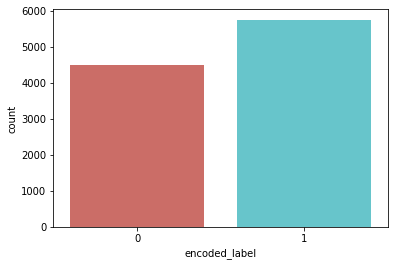

In [0]:
create_distribution(train_news)

#### **Distribution for Test News**

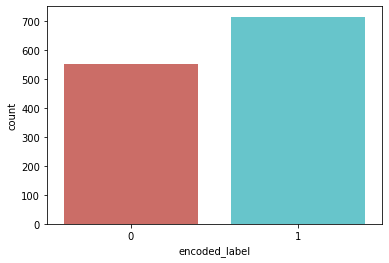

In [0]:
create_distribution(test_news)

#### **Distribution for Validate News**

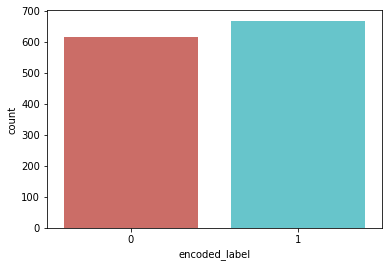

In [0]:
create_distribution(valid_news)

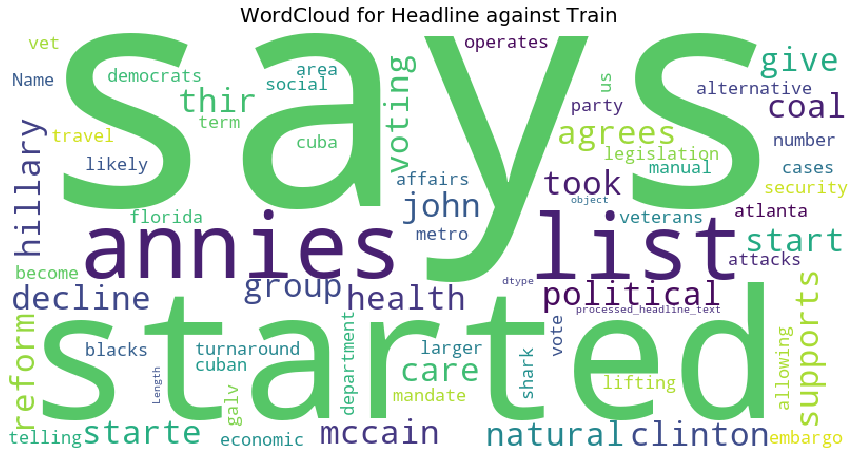

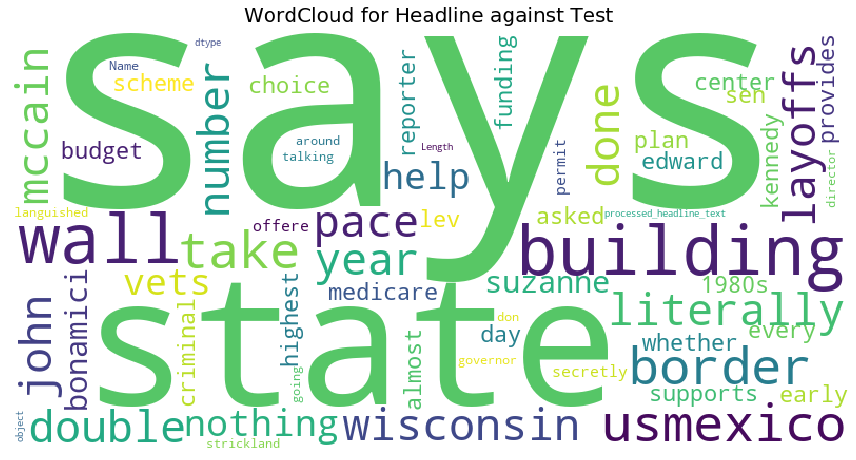

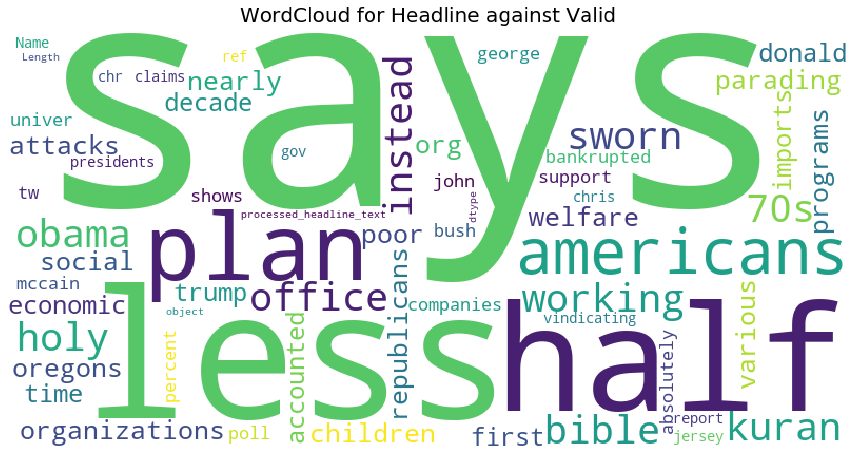

In [0]:
create_word_cloud(train_news,processedheadlinecolname,'WordCloud for Headline against Train')
create_word_cloud(test_news,processedheadlinecolname,'WordCloud for Headline against Test')
create_word_cloud(valid_news,processedheadlinecolname,'WordCloud for Headline against Valid')

## **Distillation - Sentiment Analysis**

In [0]:
!pip install vaderSentiment
import nltk.sentiment
import nltk
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

     |████████████████████████████████| 133kB 2.8MB/s 
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
snt = senti.polarity_scores(train_news[processedheadlinecolname][0])
print("{:-<40} \n{}".format([processedheadlinecolname][0], str(snt)))
print ([snt['neg'],snt['neu'],snt['pos']])
print (snt['compound'])

processed_headline_text----------------- 
{'neg': 0.136, 'neu': 0.636, 'pos': 0.227, 'compound': 0.25}
[0.136, 0.636, 0.227]
0.25


In [0]:
def identify_sentiment_on_text(text):
    snt = senti.polarity_scores(text)
    # print("{:-<40} \n{}".format(text, str(snt)))
    # print ([snt['neg'],snt['neu'],snt['pos']])
    # print (snt['compound'])
    return pd.Series([snt['compound'], [snt['neg'],snt['neu'],snt['pos']]])

In [0]:
def update_sentiment_results_to_dataset(dataframe,sentimentcolnames,coltoapplysentiment):
    dataframe[sentimentcolnames] = dataframe.apply(
    lambda row: identify_sentiment_on_text(
        row[coltoapplysentiment]), axis=1)
    return dataframe

In [0]:
sentimentcolnames = ['headline_sentiment_compound','headline_sentiment_polarity_vector']
train_news = update_sentiment_results_to_dataset(train_news,sentimentcolnames,processedheadlinecolname)
train_news.head()

test_news = update_sentiment_results_to_dataset(test_news,sentimentcolnames,processedheadlinecolname)
test_news.head()

valid_news = update_sentiment_results_to_dataset(valid_news,sentimentcolnames,processedheadlinecolname)
valid_news.head()


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocounts,pantsonfirecounts,context,encoded_label,index,processed_headline_text,headline_sentiment_compound,headline_sentiment_polarity_vector
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0,0,less americans working 70s,0.0000,"[0.0, 1.0, 0.0]"
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,0,1,obama sworn office holy bible instead kuran th...,0.0000,"[0.0, 1.0, 0.0]"
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0,2,says organizations parading social welfare org...,-0.3400,"[0.138, 0.862, 0.0]"
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,1,3,says nearly half oregons children poor,-0.4767,"[0.383, 0.617, 0.0]"
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,1,4,attacks republicans various programs economic ...,-0.4404,"[0.182, 0.818, 0.0]"


## **Feature Selection**
#### **Top 10 Features Selected based on research articles**

1. Social acceptance = # of likes, # of comments (short term utility)
2. Bias Score
3. Spam Score
4. Website credibility/ Domain Ranking
5. Author credibility
6. Political Affliation
7. Occurance Location (Probability of announcing on Radio or Press release being fake is low)
8. Sensationalism/Psychology Utility - agreeing with reader's prior beliefs
9. Frequency Heuristic - Constant repetition makes them believe (Sensationlism)
10. Echo Chamber - Forming groups and spreading opinions
11. Visual - Images, Links, Videos

### **Bag of Words**
We will start with simple bag of words technique 
creating feature vector - document term matrix

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer

### **CounterVectorizer & Stats**

In [0]:
countV = CountVectorizer()
train_count = countV.fit_transform(train_news[headlinecolname].values)
def get_countVectorizer_stats():
    
    #vocab size
    train_count.shape

    #check vocabulary using below command
    print(countV.vocabulary_)

    #get feature names
    print(countV.get_feature_names()[:25])

#print(countV)
#print(train_count)
#get_countVectorizer_stats()

#### **TF-IDF**
Create tf-df frequency features


In [0]:
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

def get_tfidf_stats():
    train_tfidf.shape
    #get train data feature names 
    print(train_tfidf.A[:10])
    
get_tfidf_stats()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### **Bag of words - with n-grams**
Using the below Options and we chose TfidfVectorizer

* countV_ngram = CountVectorizer(ngram_range=(1,3),stop_words='english')
* tfidf_ngram  = TfidfTransformer(use_idf=True,smooth_idf=True)
* tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)

In [0]:
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)

## **Classifier**

### First we will use bag of words techniques - CountVectorizer


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#### **Building Classifier using Naives Bayes regression**

In [0]:
nb_pipeline = Pipeline([
        ('NBCV',countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_nb = nb_pipeline.predict(test_news[headlinecolname])
np.mean(predicted_nb == test_news[labelcolname])

0.6101026045777427

#### **Building Classifier using Logistic regression**

In [0]:
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_LogR = logR_pipeline.predict(test_news[headlinecolname])
np.mean(predicted_LogR == test_news[labelcolname])

0.6085240726124704

#### **Building Classifier using Linear SVM Classifier**

In [0]:
svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_svm = svm_pipeline.predict(test_news[headlinecolname])
np.mean(predicted_svm == test_news[labelcolname])

0.5919494869771112

#### **Building Classifier using SVM Stochastic Gradient Descent on hinge loss**

In [0]:
sgd_pipeline = Pipeline([
        ('svm2CV',countV),
        ('svm2_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
        ])

sgd_pipeline.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_sgd = sgd_pipeline.predict(test_news[headlinecolname])
np.mean(predicted_sgd == test_news[labelcolname])

0.6250986582478295

#### **Building Classifier using RandomForestClassifier**

In [0]:
#random forest
random_forest = Pipeline([
        ('rfCV',countV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_rf = random_forest.predict(test_news[headlinecolname])
np.mean(predicted_rf == test_news[labelcolname])

0.606156274664562

In [0]:
#User defined functon for K-Fold cross validation
def build_confusion_matrix2(classifier):
    
    k_fold = KFold(n_splits=5, random_state=None, shuffle=False)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind][headlinecolname] 
        train_y = train_news.iloc[train_ind][labelcolname]
    
        test_text = train_news.iloc[test_ind][headlinecolname]
        test_y = train_news.iloc[test_ind][labelcolname]
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    return (print('Total statements classified:', len(train_news)),
    print('Score:', sum(scores)/len(scores)),
    print('score length', len(scores)),
    print('Confusion matrix:'),
    print(confusion))

In [0]:
import seaborn as sns
#User defined functon for K-Fold cross validatoin
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5, random_state=None, shuffle=False)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind][headlinecolname] 
        train_y = train_news.iloc[train_ind][labelcolname]
    
        test_text = train_news.iloc[test_ind][headlinecolname]
        test_y = train_news.iloc[test_ind][labelcolname]
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    print('Total statements classified:{}'.format(len(train_news)))
    print('Score:{}'.format(sum(scores)/len(scores)))
    print('Score length:{}'.format(len(scores)))
    cm = confusion
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Total statements classified:10240
Score:0.6698307105452173
Score length:5


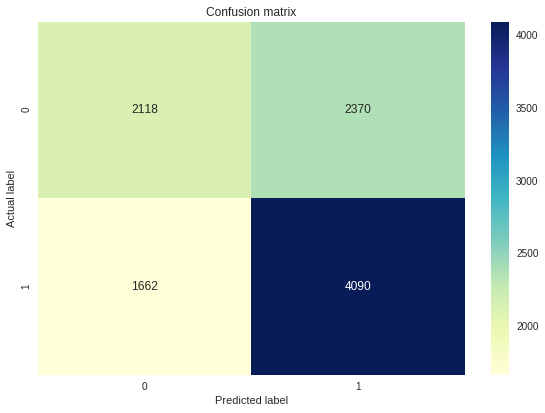

In [0]:
#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline)

Total statements classified:10240
Score:0.6467410480534144
Score length:5


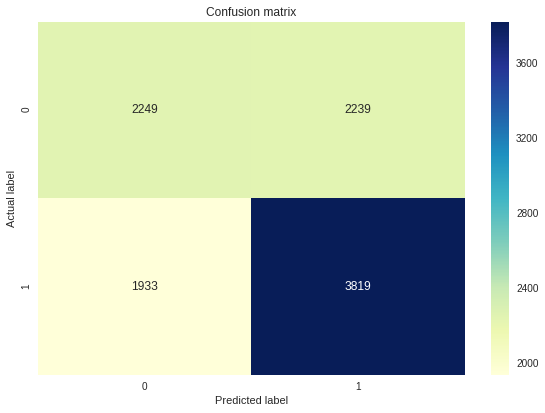

In [0]:
build_confusion_matrix(logR_pipeline)

Total statements classified:10240
Score:0.6105735024319964
Score length:5


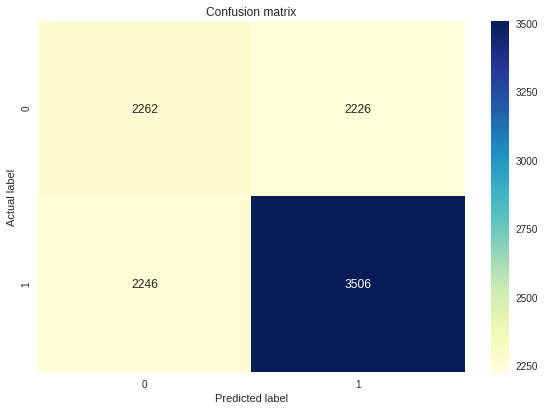

In [0]:
build_confusion_matrix(svm_pipeline)

Total statements classified:10240
Score:0.6626791694936627
Score length:5


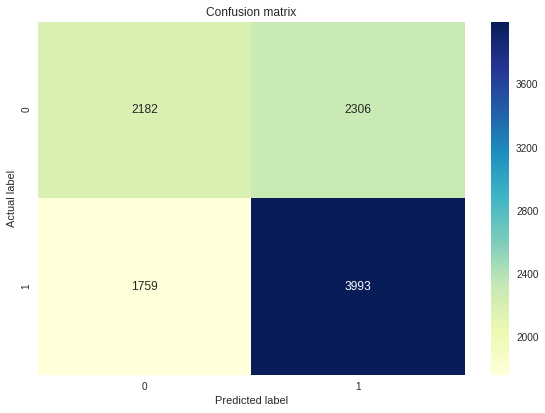

In [0]:
build_confusion_matrix(sgd_pipeline)

Total statements classified:10240
Score:0.6954637426022062
Score length:5


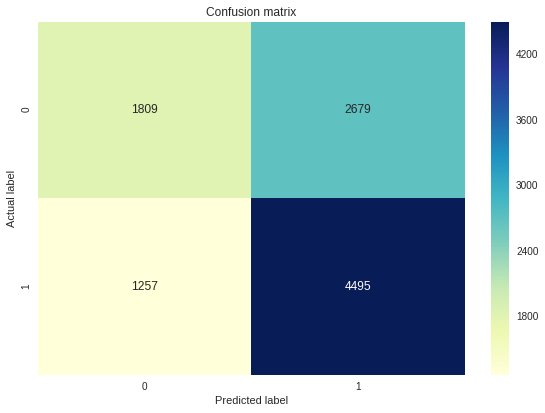

In [0]:
build_confusion_matrix(random_forest)

### **NGrams TF-IDF**
So far we have used bag of words technique to extract the features and passed those featuers into classifiers. We have also seen the
f1 scores of these classifiers. now lets enhance these features using term frequency weights with various n-grams

#### **Building Classifier using Naives Bayes regression**

In [0]:
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf',tfidf_ngram),
        ('nb_clf',MultinomialNB())])


nb_pipeline_ngram.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_nb_ngram = nb_pipeline_ngram.predict(test_news[headlinecolname])
np.mean(predicted_nb_ngram == test_news[labelcolname])

0.6029992107340174

#### **Building Classifier using Logistic regression**

In [0]:
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf',tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_ngram.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news[headlinecolname])
np.mean(predicted_LogR_ngram == test_news[labelcolname])

0.6187845303867403

#### **Building Classifier using Linear SVM Classifier**

In [0]:
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline_ngram.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news[headlinecolname])
np.mean(predicted_svm_ngram ==test_news[labelcolname])

0.6211523283346487

#### **Building Classifier using SVM Stochastic Gradient Descent on hinge loss**

In [0]:
sgd_pipeline_ngram = Pipeline([
         ('sgd_tfidf',tfidf_ngram),
         ('sgd_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
         ])

sgd_pipeline_ngram.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_sgd_ngram = sgd_pipeline_ngram.predict(test_news[headlinecolname])
np.mean(predicted_sgd_ngram == test_news[labelcolname])

0.56353591160221

#### **Building Classifier using RandomForestClassifier**

In [0]:
#random forest classifier
random_forest_ngram = Pipeline([
        ('rf_tfidf',tfidf_ngram),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3))
        ])
    
random_forest_ngram.fit(train_news[headlinecolname],train_news[labelcolname])
predicted_rf_ngram = random_forest_ngram.predict(test_news[headlinecolname])
np.mean(predicted_rf_ngram == test_news[labelcolname])

0.6006314127861089

Total statements classified:10240
Score:0.7224920919443518
Score length:5


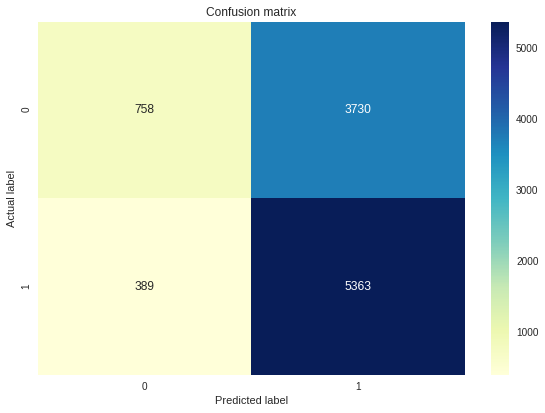

In [0]:
#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline_ngram)


Total statements classified:10240
Score:0.7044355553757985
Score length:5


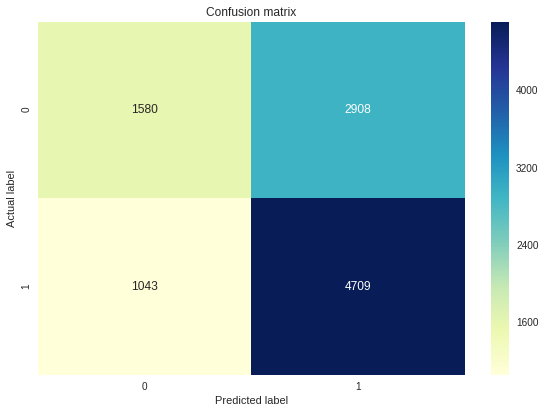

In [0]:
build_confusion_matrix(logR_pipeline_ngram)


Total statements classified:10240
Score:0.6790399132404719
Score length:5


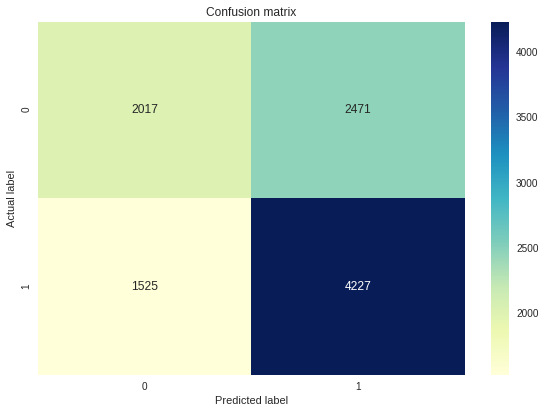

In [0]:
build_confusion_matrix(svm_pipeline_ngram)

Total statements classified:10240
Score:0.7190643331130575
Score length:5


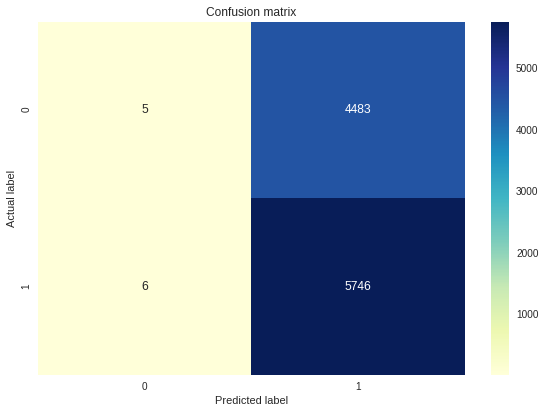

In [0]:
build_confusion_matrix(sgd_pipeline_ngram)

Total statements classified:10240
Score:0.6602575208508185
Score length:5


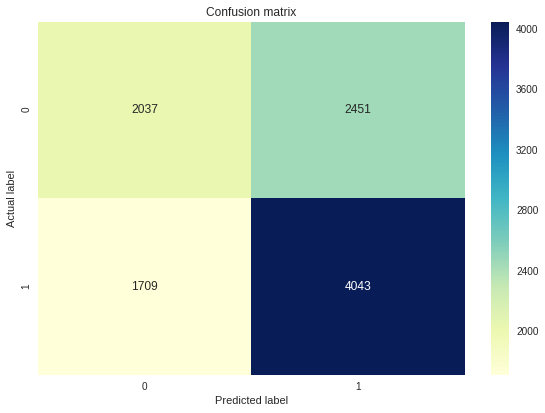

In [0]:

build_confusion_matrix(random_forest_ngram)

In [0]:

print("Logistic Regression")
print(classification_report(test_news[labelcolname], predicted_LogR_ngram))

print("Random Forest")
print(classification_report(test_news[labelcolname], predicted_rf_ngram))

print("SVM")
print(classification_report(test_news[labelcolname], predicted_svm_ngram))

print("Stochastic Gradient Descent")
print(classification_report(test_news[labelcolname], predicted_sgd_ngram))

print("Naive Bayes")
print(classification_report(test_news[labelcolname], predicted_nb_ngram))

Logistic Regression
              precision    recall  f1-score   support

           0       0.60      0.37      0.46       553
           1       0.62      0.81      0.71       714

    accuracy                           0.62      1267
   macro avg       0.61      0.59      0.58      1267
weighted avg       0.62      0.62      0.60      1267

Random Forest
              precision    recall  f1-score   support

           0       0.55      0.45      0.49       553
           1       0.63      0.72      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.58      0.58      1267
weighted avg       0.59      0.60      0.59      1267

SVM
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       553
           1       0.64      0.75      0.69       714

    accuracy                           0.62      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.62      0.62   

#### **Inference for best performing model**

Out of all the models fitted, we would take 2 best performing model.
We would call them candidate models from the confusion matrix, we can see that random forest and logistic regression are best performing in terms of precision and recall 
(take a look into false positive and true negative counts which appeares to be low compared to rest of the models)

## **Distillation - LDA Topic Models**

Using the preprocessandspellcheck method did the data Pre-processing on headlinetext

#### **Create a function to convert text to word tokens from cleaned dataset**

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result

#### **Documents Class - Helper Class to join and tokenize**
Create a class that would geenrate a list of tokenized sentences from dataset, which can then be converted to vector

In [0]:
class ProcessedDocuments(object):
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)


#### **Function that will create a word2vec model**

This function will take input of all documents as an numpy array and create a model, we use gensim Word2Vec to create the model

In [0]:
def get_word2vec(sentences, location):
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk as ' + '/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Model/' + location)
    model.save('/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Model/' + location)
    return model

#### **Create a function to tokenize docs**

In [0]:
def get_tokenized_docs(dataframe,colname):
    documents_locale = dataframe[[colname]]
    tokenized_docs_local = documents_locale[colname].map(get_word_tokens)
    return tokenized_docs_local

#### **Create a function to build the dictionary and tokenized docs for given** **feature**

Below function does the following
* #### **Dictionary**
Returns Dictionary given, dataframe and column name
* #### **Tokenizeddocs**
Returns Tokenizeddocs, of the all the words in a text in that column can be used for bow_corpus
* #### **Dictionary is filtered using Gensim filter_extremes**
    Filter out tokens that appear in less than 15 documents (absolute number) or more than 0.5 documents (fraction of total corpus size, not absolute number). after the above two steps, keep only the first 100000 most frequent tokens.


In [0]:
def get_dictionary_print_words(dataframe,colname):
    tokenized_docs_local = get_tokenized_docs(dataframe,colname)
    dictionary_gensim = gensim.corpora.Dictionary(tokenized_docs_local)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim,tokenized_docs_local

#### **Create a function to build bow_corpus from dictionary and tokenized_docs**

In [0]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim,tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local,dictionary_gensim

#### **Create a function to build tfidf_corpus from bow_corpus**

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [0]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n ######## TFIDF VECTOR FIRST ITEM ########')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

#### **Create a function to run ldamodel and print top 10 topics**

In [0]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

#### **Create a function to run ldamodel and print top 10 topics**

In [0]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

#### **Create a function to enrich data with lda topics, lda topics score, top words**

In [0]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

#### **Create a function that can enrich topic data to dataframe**

In [0]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

### **Bag of Words**

#### **Create a dictionary and tokens**
Create dictionary from ‘processed_headline_text’ containing the number of times a word appears in the training set.

In [0]:
bow_corpus_headline,dictionary_headline = get_bow_corpus_print_sample(train_news,processedheadlinecolname)

######## DICTIONARY Words and occurences ########
0 abortions
1 annies
2 demand
3 group
4 list
5 political
6 says
7 supports
8 thirdtrimester
9 administration
10 begin

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

 ######## PREVIEW BOW ########
Word 0 ("abortions") appears 1 time.
Word 1 ("group") appears 1 time.
Word 2 ("list") appears 1 time.
Word 3 ("political") appears 1 time.
Word 4 ("says") appears 1 time.
Word 5 ("supports") appears 1 time.


#### **Running LDA using Bag of Words**
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [0]:
lda_model_headline,lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline,10,dictionary_headline)

0::['says', 'percent', 'every', 'state', 'health', 'year', 'government', 'care', 'plan', 'security']
1::['says', 'health', 'care', 'america', 'country', 'state', 'percent', 'insurance', 'governor', 'even']
2::['year', 'taxes', 'states', 'school', 'texas', 'percent', 'people', 'last', 'united', 'says']
3::['would', 'since', 'state', 'says', 'office', 'million', 'percent', 'every', 'bill', 'took']
4::['jobs', 'says', 'president', 'million', 'obama', 'barack', 'created', 'percent', 'said', 'time']
5::['says', 'city', 'obamacare', 'rhode', 'island', 'every', 'obama', 'said', 'austin', 'would']
6::['says', 'percent', 'years', 'budget', 'state', 'scott', 'wisconsin', 'last', 'medicare', 'would']
7::['obama', 'says', 'president', 'percent', 'barack', 'years', 'people', 'state', 'american', 'states']
8::['says', 'health', 'care', 'percent', 'people', 'voted', 'taxes', 'women', 'clinton', 'obama']
9::['says', 'percent', 'state', 'states', 'rate', 'united', 'years', 'texas', 'people', 'senate']


#### **Generate TF-IDF bow_corpus**
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [0]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 ######## TFIDF VECTOR FIRST ITEM ########
[(0, 0.44124760810679226),
 (1, 0.4432212674094083),
 (2, 0.4986239258355844),
 (3, 0.4320502154718752),
 (4, 0.11768062592220696),
 (5, 0.39964173785229923)]


#### **Running LDA using TF-IDF**
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [0]:
lda_tfidf_model_headline = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['says', 'state', 'court', 'obama', 'president', 'jobs', 'taxes', 'federal', 'scott', 'voted']
1::['obama', 'says', 'percent', 'states', 'barack', 'million', 'jobs', 'united', 'president', 'rate']
2::['says', 'florida', 'obama', 'bush', 'percent', 'said', 'president', 'population', 'would', 'barack']
3::['says', 'years', 'donald', 'trump', 'party', 'ever', 'state', 'jobs', 'percent', 'half']
4::['says', 'crist', 'made', 'right', 'states', 'economy', 'state', 'country', 'charlie', 'percent']
5::['percent', 'says', 'campaign', 'health', 'care', 'state', 'security', 'social', 'america', 'nearly']
6::['percent', 'says', 'years', 'average', 'schools', 'school', 'texas', 'health', 'women', 'states']
7::['says', 'texas', 'year', 'state', 'percent', 'illegal', 'taxes', 'water', 'years', 'iran']
8::['says', 'romney', 'medicare', 'billion', 'health', 'care', 'mitt', 'obamacare', 'americans', 'percent']
9::['percent', 'country', 'says', 'spent', 'obama', 'never', 'killed', 'passed', 'police', 

#### **Headline_text word2Vec Model**
Create a Word2Vec model with the list of headline_text

In [0]:
import nltk
nltk.download('punkt')

w2vec = get_word2vec(
    ProcessedDocuments(
        train_news[processedheadlinecolname].values, 
        test_news[processedheadlinecolname].values, 
        valid_news[processedheadlinecolname].values
    ),
    'w2vmodel'
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Model done training. Saving to disk as /content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Model/w2vmodel


#### **Visualize t-SNE of MeanEmbeddingVector for word2vec**

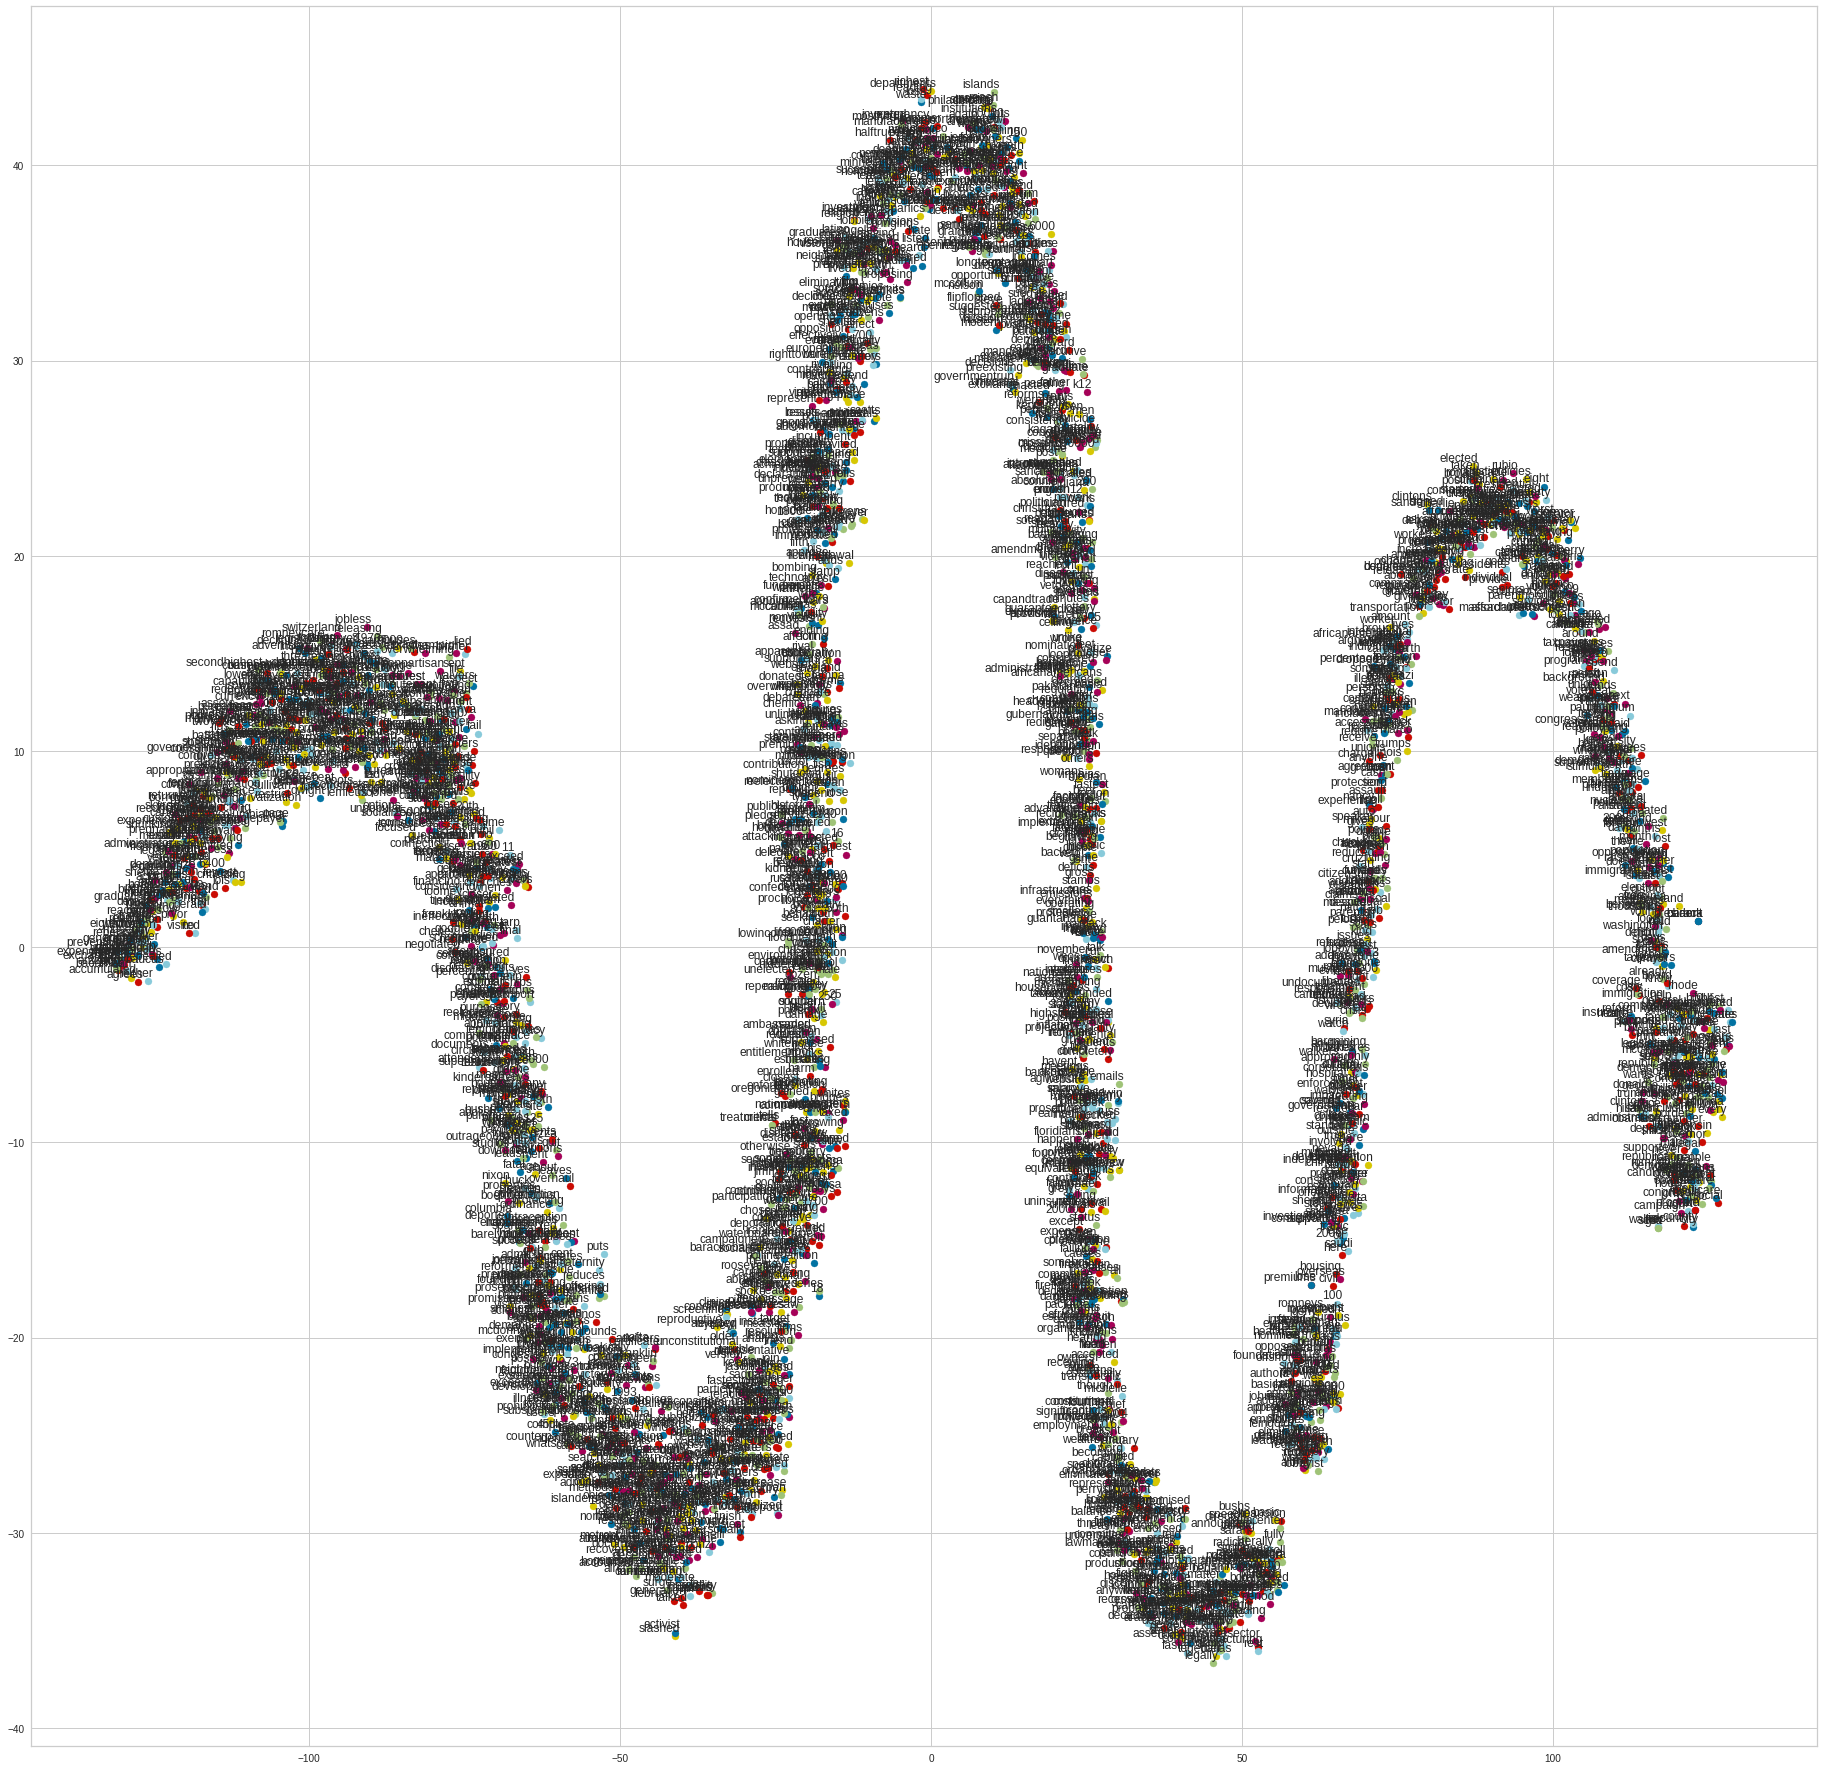

In [0]:
tsne_plot(w2vec,32,32)

#### **Semisupervised Labeling**
Based on train,test and valid data explored the topic scores for sample data and identified below topics

In [0]:
semisupervised_headline_topic_labels = ['american_clinton_vote','trump_republic_vote',
                                        'obama_immigr_support','health_care_job',
                                        'employe_percent_secur','school_spend_democrat',
                                        'tax_rais_debt','american_peopl_spend',
                                        'creat_job_million','feder_cost_colleg']

#### **Assign Topic details to Train, Test and Valid Data Set**

In [0]:
headlinetopiccolnames = ['headline_lda_topic_number','headline_lda_topic_score','headline_lda_topic_topwords']
train_news = update_lda_results_to_dataset(
    train_news,headlinetopiccolnames,headlinecolname,
    dictionary_headline,lda_model_headline,lda_headline_topic_words)
train_news.head()

test_news = update_lda_results_to_dataset(
    test_news,headlinetopiccolnames,headlinecolname,
    dictionary_headline,lda_model_headline,lda_headline_topic_words)
test_news.head()

valid_news = update_lda_results_to_dataset(
    valid_news,headlinetopiccolnames,headlinecolname,
    dictionary_headline,lda_model_headline,lda_headline_topic_words)
valid_news.head()  

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocounts,pantsonfirecounts,context,encoded_label,index,processed_headline_text,headline_sentiment_compound,headline_sentiment_polarity_vector,headline_lda_topic_number,headline_lda_topic_score,headline_lda_topic_topwords
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0,0,less americans working 70s,0.0000,"[0.0, 1.0, 0.0]",8,0.819960,says health care percent people voted taxes wo...
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,0,1,obama sworn office holy bible instead kuran th...,0.0000,"[0.0, 1.0, 0.0]",3,0.553169,would since state says office million percent ...
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0,2,says organizations parading social welfare org...,-0.3400,"[0.138, 0.862, 0.0]",7,0.481618,obama says president percent barack years peop...
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,1,3,says nearly half oregons children poor,-0.4767,"[0.383, 0.617, 0.0]",1,0.615560,says health care america country state percent...
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,1,4,attacks republicans various programs economic ...,-0.4404,"[0.182, 0.818, 0.0]",8,0.611565,says health care percent people voted taxes wo...


### **LDA2VEC**

lda2vec is an extension of word2vec and LDA that jointly learns word, document, and topic vectors. It is  specifically builds on top of the skip-gram model of word2vec to generate word vectors. With lda2vec, instead of using the word vector directly to predict context words, we leverage a context vector to make the predictions. This context vector is created as the sum of two other vectors: the word vector and the document vector

#### **LDA to Vector Model lda2vec**
Create a LDA2Vec model with the list of topic top words

In [0]:
lda2vec = get_word2vec(
    ProcessedDocuments(
        train_news['headline_lda_topic_topwords'].values, 
        test_news['headline_lda_topic_topwords'].values, 
        valid_news['headline_lda_topic_topwords'].values
    ),
    'lda2vecmodel'
)
   

Model done training. Saving to disk as /content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/Model/lda2vecmodel


#### **Visualize t-SNE of MeanEmbeddingVector for lda2vec**

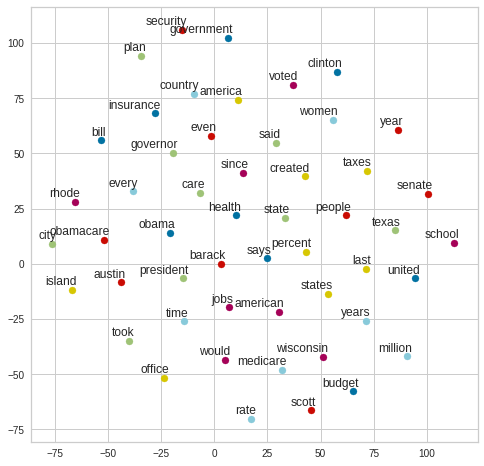

In [0]:
tsne_plot(lda2vec,8,8)

## **Complex Feature - Context**

Taking context as a feature which is complex, however there are lot of unique contexts in dataset.

### **Steps to accomplish**
* #### Identify unique context values which is huge
* #### Reduce it to 10 meaningful contexts using LDA
* #### Semisupervised context topics
* #### We will enrich dataset with new topic labels
* #### Tag the documents using gensim tagging
* #### Apply doc2vec on the tagged documents
* #### Distill it with LDA topics on headline
* #### Distill it with Sentiment Analysis on headline
* #### New vector formed will be part of my polynomial equation


In [0]:
contextcolname = 'context'
processedcontextcolname = 'processed_context'

#### **Define function to preprocess context**

In [0]:
def preprocess_context(text):
    text = lemmatize_stemming(text)
    #print('Lemmatized :: ' + text)
    text = remove_punctuation(text)
    #print('Punctuation removed :: ' + text)
    return text

In [0]:
preprocess_context(str('a floor speech.'))

'a floor speech'

#### **Apply Preprocessing for all datasets on Context**

In [0]:
def apply_context_preprocess_dataframe(dflocal):
    dflocal[contextcolname] = dflocal[contextcolname].fillna('others')
    dflocal[processedcontextcolname] = dflocal.apply(
        lambda row: preprocess_context(str(row[contextcolname])), axis=1)
    return dflocal

train_news = apply_context_preprocess_dataframe(train_news)
test_news = apply_context_preprocess_dataframe(test_news)
valid_news = apply_context_preprocess_dataframe(valid_news)

dfcontextunique = train_news
dfcontextunique = dfcontextunique.append([test_news, valid_news])

In [0]:
len(dfcontextunique.context.unique())

5143

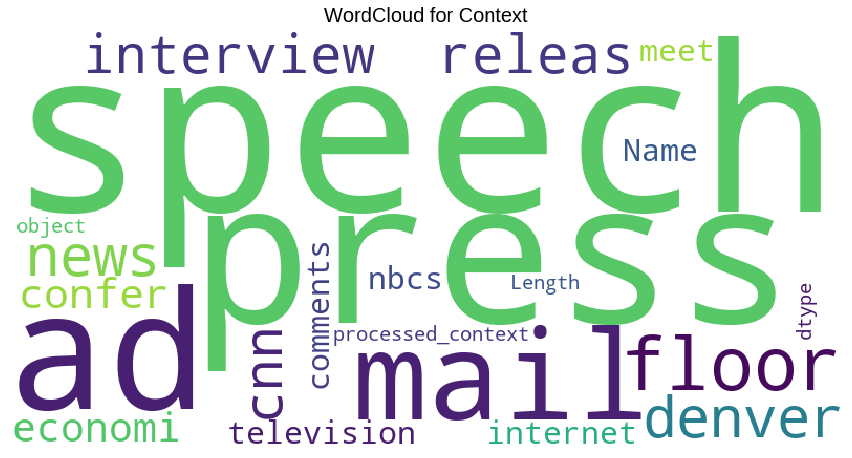

In [0]:
create_word_cloud(dfcontextunique,processedcontextcolname,'WordCloud for Context')

#### **Dictionary of context and Bag of words Vector**

In [0]:
bow_corpus_context,dictionary_context = get_bow_corpus_print_sample(dfcontextunique,contextcolname)

######## DICTIONARY Words and occurences ########
0 mailer
1 floor
2 speech
3 denver
4 news
5 release
6 interview
7 online
8 opinion
9 piece
10 press

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1)]

 ######## PREVIEW BOW ########
Word 0 ("mailer") appears 1 time.


#### **Run LDA against bow context to get top topics for context**

In [0]:
lda_model_context,lda_context_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_context,10,dictionary_context)

0::['campaign', 'interview', 'show', 'news', 'with', 'mailer', 'website', 'appearance', 'commentary', 'newspaper']
1::['press', 'release', 'meet', 'blog', 'post', 'iowa', 'media', 'campaign', 'meme', 'social']
2::['speech', 'mail', 'chain', 'newsletter', 'email', 'book', 'times', 'political', 'university', 'piece']
3::['interview', 'debate', 'radio', 'presidential', 'with', 'msnbc', 'republican', 'morning', 'vegas', 'business']
4::['democratic', 'speech', 'convention', 'meeting', 'debate', 'national', 'town', 'hall', 'texas', 'party']
5::['speech', 'state', 'house', 'floor', 'senate', 'union', 'address', 'hearing', 'committee', 'republican']
6::['news', 'release', 'statement', 'article', 'website', 'interview', 'campaign', 'sunday', 'miami', 'congressional']
7::['conference', 'week', 'tweet', 'this', 'press', 'news', 'campaign', 'commercial', 'broadcast', 'rally']
8::['television', 'interview', 'video', 'campaign', 'face', 'nation', 'with', 'youtube', 'debate', 'week']
9::['comments', 

In [0]:
semisupervised_context_topics = ['interview_campaign_appearance','pressrelease_media',
                                 'book_newsletter','presidential_debate',
                                 'townhall_meeting','senate_house_floor',
                                 'news_release_nation','twitter_online_campaign'
                                'interview_media','public_comments']

#### **Assign context topics back to dataset**

In [0]:
contexttopiccolnames = ['context_lda_topic_number','context_lda_topic_score','context_lda_topic_topwords']
contexttopicnamecol = 'context_lda_topic_name'
train_news = update_lda_results_to_dataset(
    train_news,contexttopiccolnames,contextcolname,
    dictionary_context,lda_model_context,lda_context_topic_words)
train_news[contexttopicnamecol] = train_news[processedcontextcolname] = train_news.apply(
        lambda row: semisupervised_context_topics[int(row['context_lda_topic_number'])-1], axis=1)
train_news.head()

test_news = update_lda_results_to_dataset(
    test_news,contexttopiccolnames,contextcolname,
    dictionary_headline,lda_model_headline,lda_headline_topic_words)
test_news[contexttopicnamecol] = test_news[processedcontextcolname] = test_news.apply(
        lambda row: semisupervised_context_topics[int(row['context_lda_topic_number'])-1], axis=1)                                                 
test_news.head()

valid_news = update_lda_results_to_dataset(
    valid_news,contexttopiccolnames,contextcolname,
    dictionary_headline,lda_model_headline,lda_headline_topic_words)
valid_news[contexttopicnamecol] = valid_news[processedcontextcolname] = valid_news.apply(
        lambda row: semisupervised_context_topics[int(row['context_lda_topic_number'])-1], axis=1)
valid_news.head() 

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocounts,pantsonfirecounts,context,encoded_label,index,processed_headline_text,headline_sentiment_compound,headline_sentiment_polarity_vector,headline_lda_topic_number,headline_lda_topic_score,headline_lda_topic_topwords,processed_context,context_lda_topic_number,context_lda_topic_score,context_lda_topic_topwords,context_lda_topic_name
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0,0,less americans working 70s,0.0000,"[0.0, 1.0, 0.0]",8,0.819960,says health care percent people voted taxes wo...,presidential_debate,4,0.549975,jobs says president million obama barack creat...,presidential_debate
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,others,0,1,obama sworn office holy bible instead kuran th...,0.0000,"[0.0, 1.0, 0.0]",3,0.553169,would since state says office million percent ...,public_comments,0,0.100000,says percent every state health year governmen...,public_comments
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0,2,says organizations parading social welfare org...,-0.3400,"[0.138, 0.862, 0.0]",7,0.481618,obama says president percent barack years peop...,book_newsletter,3,0.549953,would since state says office million percent ...,book_newsletter
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,1,3,says nearly half oregons children poor,-0.4767,"[0.383, 0.617, 0.0]",1,0.615560,says health care america country state percent...,public_comments,0,0.100000,says percent every state health year governmen...,public_comments
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,1,4,attacks republicans various programs economic ...,-0.4404,"[0.182, 0.818, 0.0]",8,0.611565,says health care percent people voted taxes wo...,presidential_debate,4,0.549977,jobs says president million obama barack creat...,presidential_debate


#### **Write enrich Data with context topics to csv for future use**

In [0]:
train_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/train_contextlda.csv", sep=',')
test_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/test_contextlda.csv", sep=',')
valid_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/valid_contextlda.csv", sep=',')

#### **Train News Distribution against context**

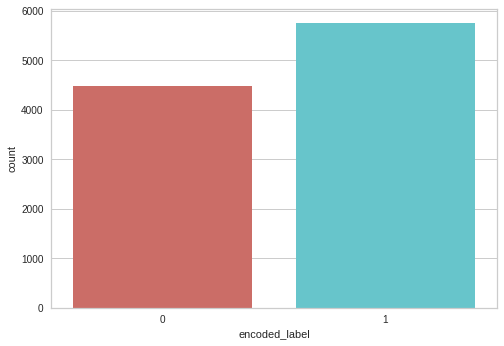

In [0]:
create_distribution(train_news)

#### **Test News Distribution against topics**

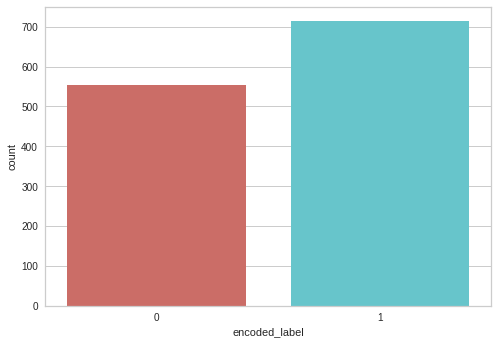

In [0]:
create_distribution(test_news)

#### **Valid News Distribution against topics**

In [0]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#### **Create function to tag Documents**

In [0]:
#tag each headline text with the label found in previous step
def tag_headline(data, coltotag, colusedtotag):
    tagged_data = []
    for index, row in data.iterrows():
        tagged_data.append(TaggedDocument(words=get_word_tokens(row[coltotag]), tags=[row[colusedtotag]]))
    return tagged_data

### **Tagging**

Tag Documents against context Train, Test and Valid

In [0]:
#tag train data and run doc2vec model
context_labelled_headlines_train = tag_headline(train_news, processedheadlinecolname, contexttopicnamecol)
print(context_labelled_headlines_train[:3])

#tag train data and run doc2vec model
context_labelled_headlines_test = tag_headline(test_news, processedheadlinecolname, contexttopicnamecol)
print(context_labelled_headlines_test[:3])

#tag train data and run doc2vec model
context_labelled_headlines_valid = tag_headline(valid_news, processedheadlinecolname, contexttopicnamecol)
print(context_labelled_headlines_valid[:3])

[TaggedDocument(words=['says', 'annies', 'list', 'political', 'group', 'supports', 'thirdtrimester', 'abortions', 'demand'], tags=['public_comments']), TaggedDocument(words=['decline', 'coal', 'start', 'started', 'natural', 'took', 'started', 'begin', 'president', 'george', 'bushs', 'administration'], tags=['townhall_meeting']), TaggedDocument(words=['hillary', 'clinton', 'agrees', 'john', 'mccain', 'voting', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran'], tags=['public_comments'])]
[TaggedDocument(words=['building', 'wall', 'usmexico', 'border', 'take', 'literally', 'years'], tags=['public_comments']), TaggedDocument(words=['wisconsin', 'pace', 'double', 'number', 'layoffs', 'year'], tags=['presidential_debate']), TaggedDocument(words=['says', 'john', 'mccain', 'done', 'nothing', 'help', 'vets'], tags=['interview_campaign_appearance'])]
[TaggedDocument(words=['less', 'americans', 'working'], tags=['presidential_debate']), TaggedDocument(words=['obama', 'sworn', 'office', 'holy'

#### **Apply Doc2Vec on Tagged Documents to created doc2vec models**
We use doc2vec as we are doing it on a sentence, would have been better to do word2vec if it were a word

In [0]:
doc2vec_model_train = Doc2Vec(documents = context_labelled_headlines_train,
                              dm=0, num_features=500, min_count=2, size=21, window=4)
doc2vec_model_test= Doc2Vec(documents = context_labelled_headlines_test,
                              dm=0, num_features=500, min_count=2, size=21, window=4)
doc2vec_model_valid= Doc2Vec(documents = context_labelled_headlines_valid,
                              dm=0, num_features=500, min_count=2, size=21, window=4)

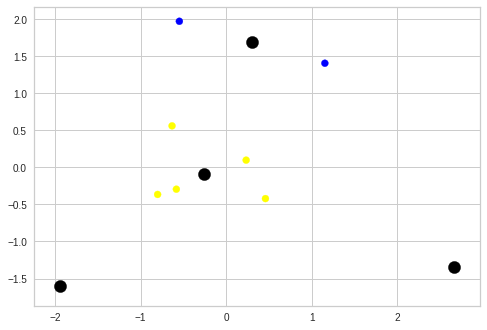

In [0]:
kmeans_cluster_visualization(doc2vec_model_train,4)

In [0]:
#Method to convert doc2vec model and tagged documents into vectors training and testing
def create_vector_for_learning(model, tagged_docs):
    #documents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    return targets, regressors

#### **Doc2Vec Model to Vector converter**
Create function to apply as lambda to convert text, doc2vecmodel to vector

In [0]:
def create_docvector(doc2vec_model,label):
    return doc2vec_model.docvecs[label]

#### **Add vector for every text in the dataset**

In [0]:
def apply_context_doc2vec(dflocal,doc2vec_model, vectorcolname, label):
    dflocal[vectorcolname] = dflocal.apply(
        lambda row: create_docvector(doc2vec_model,str(row[label])), axis=1)
    return dflocal

#### **Update Dataset with vectors identified by Doc2Vec applied on context**

In [0]:
contextdoc2veccolumn = 'content_doc2vec_vector'
train_news = apply_context_doc2vec(train_news, doc2vec_model_train,contextdoc2veccolumn,contexttopicnamecol)
train_news.head()

test_news = apply_context_doc2vec(test_news, doc2vec_model_test,contextdoc2veccolumn,contexttopicnamecol)
test_news.head()

valid_news = apply_context_doc2vec(valid_news, doc2vec_model_valid,contextdoc2veccolumn,contexttopicnamecol)
valid_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocounts,pantsonfirecounts,context,encoded_label,index,processed_headline_text,headline_sentiment_compound,headline_sentiment_polarity_vector,headline_lda_topic_number,headline_lda_topic_score,headline_lda_topic_topwords,processed_context,context_lda_topic_number,context_lda_topic_score,context_lda_topic_topwords,context_lda_topic_name,content_doc2vec_vector
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0,0,less americans working 70s,0.0000,"[0.0, 1.0, 0.0]",8,0.819960,says health care percent people voted taxes wo...,presidential_debate,4,0.549975,jobs says president million obama barack creat...,presidential_debate,"[1.3137674, -0.009960563, 0.9172084, 0.3821911..."
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,others,0,1,obama sworn office holy bible instead kuran th...,0.0000,"[0.0, 1.0, 0.0]",3,0.553169,would since state says office million percent ...,public_comments,0,0.100000,says percent every state health year governmen...,public_comments,"[1.2810143, 0.04334972, 0.91394097, 0.35892418..."
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0,2,says organizations parading social welfare org...,-0.3400,"[0.138, 0.862, 0.0]",7,0.481618,obama says president percent barack years peop...,book_newsletter,3,0.549953,would since state says office million percent ...,book_newsletter,"[0.93924594, 0.032870688, 0.6054743, 0.2467011..."
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,1,3,says nearly half oregons children poor,-0.4767,"[0.383, 0.617, 0.0]",1,0.615560,says health care america country state percent...,public_comments,0,0.100000,says percent every state health year governmen...,public_comments,"[1.2810143, 0.04334972, 0.91394097, 0.35892418..."
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,1,4,attacks republicans various programs economic ...,-0.4404,"[0.182, 0.818, 0.0]",8,0.611565,says health care percent people voted taxes wo...,presidential_debate,4,0.549977,jobs says president million obama barack creat...,presidential_debate,"[1.3137674, -0.009960563, 0.9172084, 0.3821911..."


In [0]:
create_docvector(doc2vec_model_train,train_news[contexttopicnamecol][0])

array([ 1.348798  ,  0.10053175,  0.98029757,  0.18187146,  0.594492  ,
        1.3122826 , -0.97296065, -1.2988639 , -1.0930871 , -1.1877825 ,
        1.275998  , -0.40192574,  1.1252775 , -0.98965824, -0.28837097,
        1.1752717 ,  0.49076203, -1.5461322 ,  0.74222547,  1.641389  ,
        1.1222755 ], dtype=float32)

In [0]:
[train_news['headline_lda_topic_score'][0],
           train_news['headline_sentiment_compound'][0],
            create_docvector(doc2vec_model_train,train_news[contexttopicnamecol][0])]

[0.6636934876441956,
 0.25,
 array([ 1.348798  ,  0.10053175,  0.98029757,  0.18187146,  0.594492  ,
         1.3122826 , -0.97296065, -1.2988639 , -1.0930871 , -1.1877825 ,
         1.275998  , -0.40192574,  1.1252775 , -0.98965824, -0.28837097,
         1.1752717 ,  0.49076203, -1.5461322 ,  0.74222547,  1.641389  ,
         1.1222755 ], dtype=float32)]

In [0]:
print (type(train_news[contextdoc2veccolumn][0]))
np.append(train_news[contextdoc2veccolumn][0],
          (train_news['headline_lda_topic_score'][0],train_news['headline_sentiment_compound'][0]))

##pd.concat([train_news['headline_lda_topic_score'],
           ##train_news['headline_sentiment_compound'],train_news[contextvectorcolumn][0]],axis=1)

<class 'numpy.ndarray'>


array([ 1.34879804,  0.10053175,  0.98029757,  0.18187146,  0.59449202,
        1.31228256, -0.97296065, -1.29886389, -1.09308708, -1.18778253,
        1.275998  , -0.40192574,  1.12527752, -0.98965824, -0.28837097,
        1.17527175,  0.49076203, -1.54613221,  0.74222547,  1.64138901,
        1.12227547,  0.66369349,  0.25      ])

In [0]:
#### Append LDA, Sentiment, Feature Vector
def apply_feature_distill_vector(dflocal, vectorcolname, doc2veccolname):
    dflocal[vectorcolname] = dflocal.apply(
        lambda row: np.append(row[doc2veccolname],
          (row['headline_lda_topic_score'],row['headline_sentiment_compound'])), axis=1)
    return dflocal

## **Create Feature Vector for Context**

* #### Append Context Feature Doc2Vec column
* #### Append LDA topic retrieved through distillation
* #### Append Sentiment Analysis Compount retrieved through distillation

In [0]:
contextfeaturevector = 'contextfeaturevector'

train_news = apply_feature_distill_vector(train_news, contextfeaturevector, contextdoc2veccolumn)
test_news = apply_feature_distill_vector(test_news,contextfeaturevector, contextdoc2veccolumn)
valid_news = apply_feature_distill_vector(valid_news,contextfeaturevector, contextdoc2veccolumn)

train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocounts,pantsonfirecounts,context,encoded_label,index,processed_headline_text,headline_sentiment_compound,headline_sentiment_polarity_vector,headline_lda_topic_number,headline_lda_topic_score,headline_lda_topic_topwords,processed_context,context_lda_topic_number,context_lda_topic_score,context_lda_topic_topwords,context_lda_topic_name,content_doc2vec_vector,contextfeaturevector
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0,0,says annies list political group supports thir...,0.2500,"[0.136, 0.636, 0.227]",5,0.663693,says city obamacare rhode island every obama s...,public_comments,0,0.549999,campaign interview show news with mailer websi...,public_comments,"[1.348798, 0.10053175, 0.98029757, 0.18187146,...","[1.3487980365753174, 0.10053174942731857, 0.98..."
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,1,1,decline coal start started natural took starte...,0.3612,"[0.0, 0.815, 0.185]",5,0.473116,says city obamacare rhode island every obama s...,townhall_meeting,5,0.699974,speech state house floor senate union address ...,townhall_meeting,"[1.3979924, 0.5813352, -0.31606406, 0.86890924...","[1.3979923725128174, 0.581335186958313, -0.316..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1,2,hillary clinton agrees john mccain voting give...,0.3182,"[0.153, 0.552, 0.294]",6,0.507395,says percent years budget state scott wisconsi...,public_comments,9,0.549989,comments column email post letter others websi...,public_comments,"[1.348798, 0.10053175, 0.98029757, 0.18187146,...","[1.3487980365753174, 0.10053174942731857, 0.98..."
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0,3,health care reform legislation likely mandate ...,0.7579,"[0.0, 0.519, 0.481]",8,0.662204,says health care percent people voted taxes wo...,senate_house_floor,6,0.699990,news release statement article website intervi...,senate_house_floor,"[1.207989, 0.09397682, 0.3133838, 0.29067293, ...","[1.207988977432251, 0.09397681802511215, 0.313..."
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,1,4,economic turnaround started term,0.0000,"[0.0, 1.0, 0.0]",6,0.481922,says percent years budget state scott wisconsi...,book_newsletter,3,0.549985,interview debate radio presidential with msnbc...,book_newsletter,"[1.0374128, 0.5305804, -0.6388442, -0.5952977,...","[1.0374127626419067, 0.5305804014205933, -0.63..."


In [0]:
def getcontextfeaturetrainvector():
    sentiment = train_news.headline_sentiment_compound.reset_index()['headline_sentiment_compound']
    topic = train_news.headline_lda_topic_score.reset_index()['headline_lda_topic_score']
    context_doc2vec = []
    for i in range(len(train_news[contexttopicnamecol])):
        context_value = train_news[contexttopicnamecol][i]
        context = doc2vec_model_train[context_value]
        context_doc2vec.append(context)
    
    context_vector = pd.concat([sentiment,topic, pd.DataFrame(context_doc2vec)],axis=1)
    return context_vector

In [0]:
def getcontextfeaturetestvector():
    sentiment = test_news.headline_sentiment_compound.reset_index()['headline_sentiment_compound']
    topic = test_news.headline_lda_topic_score.reset_index()['headline_lda_topic_score']
    context_doc2vec = []
    for i in range(len(test_news[contexttopicnamecol])):
        context_value = test_news[contexttopicnamecol][i]
        context = doc2vec_model_test[context_value]
        context_doc2vec.append(context)
    
    context_vector = pd.concat([sentiment,topic, pd.DataFrame(context_doc2vec)],axis=1)
    return context_vector

In [0]:
context_vector = getcontextfeaturetrainvector()

In [0]:
context_vector_test = getcontextfeaturetestvector()

In [0]:
#Get train and test data for classification
X_train = getcontextfeaturetrainvector()
y_train = train_news['encoded_label']

X_test = getcontextfeaturetestvector()
y_test = test_news['encoded_label']

In [0]:
#perform vector classification using SVM
from sklearn.svm import SVC
fake_news_svm_classifier = SVC(kernel = 'linear', random_state = 42)
model = fake_news_svm_classifier.fit(X_train,y_train)
y_pred = model.predict(X_test)
estimate_score(y_test, y_pred)

accuracy: 56.353591160220994
precision: [0.         0.56353591]
recall: [0. 1.]
fscore: [0.         0.72084806]
support: [553 714]


In [0]:
#perform vector classification using Logistic Regression
from sklearn.linear_model import  LogisticRegression
fake_news_classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
fake_news_classifier.fit(X_train, y_train)
y_pred = fake_news_classifier.predict(X_test)
estimate_score(y_test, y_pred)

accuracy: 56.353591160220994
precision: [0.         0.56353591]
recall: [0. 1.]
fscore: [0.         0.72084806]
support: [553 714]


In [0]:
feature = []
for index,row in X_test.iterrows():
    feature.append(row.tolist())
    
final_data = []
for i in range(len(test_news)):
    data = {}
    headline = test_news['headline_text'][i]
    encoded_label = test_news['encoded_label'][i]
    context_vector = feature[i]
    
    data = {'headline_text':headline, 'encoded_label':encoded_label, 'context_vector':context_vector}
    final_data.append(data)

test_feature = pd.DataFrame(final_data)
test_feature.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/test_contextfeature.csv", sep=',')

In [0]:
feature = []
for index,row in X_train.iterrows():
    feature.append(row.tolist())
    
final_data = []
for i in range(len(train_news)):
    data = {}
    headline = train_news['headline_text'][i]
    encoded_label = train_news['encoded_label'][i]
    context_vector = feature[i]
    
    data = {'headline_text':headline, 'encoded_label':encoded_label, 'context_vector':context_vector}
    final_data.append(data)

train_feature = pd.DataFrame(final_data)
train_feature.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/train_contextfeature.csv", sep=',')

In [0]:
train_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/train_contextfeature.csv", sep=',')
test_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/test_contextfeature.csv", sep=',')
valid_news.to_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/valid_contextfeature.csv", sep=',')

## **Conclusion**

cfcf.predict(text) returned "0". This means that above news is fake news. Since I added label 0 for fake news and 1 for true news.

**Comparing the metrics obtained from different algorithms**

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Metric", "Naive Bayes", "Logistic Regression", "SVM", "Stochastic Gradient Descent","Random Forest"]

x.add_row(["Accuracy Score ", 0.66, 0.64,0.61,0.66,0.69])
x.add_row(["Precision (0)",0.69, 0.60,0.59,0.00,0.55])
x.add_row(["Precision (1)",0.59,0.62,0.64,0.56,0.63])
x.add_row(["Recall(0)",0.17,0.37,0.45,0.00,0.45])
x.add_row(["Recall(1)",0.94,0.81,0.75,1.00,0.71])
x.add_row(["F1-score(0)",0.27,0.46,0.51,0.00,0.50])
x.add_row(["F1-score(1)",0.73,0.71,0.69,0.72,0.67])



print(x)

+-----------------+-------------+---------------------+------+-----------------------------+---------------+
|      Metric     | Naive Bayes | Logistic Regression | SVM  | Stochastic Gradient Descent | Random Forest |
+-----------------+-------------+---------------------+------+-----------------------------+---------------+
| Accuracy Score  |     0.66    |         0.64        | 0.61 |             0.66            |      0.69     |
|  Precision (0)  |     0.69    |         0.6         | 0.59 |             0.0             |      0.55     |
|  Precision (1)  |     0.59    |         0.62        | 0.64 |             0.56            |      0.63     |
|    Recall(0)    |     0.17    |         0.37        | 0.45 |             0.0             |      0.45     |
|    Recall(1)    |     0.94    |         0.81        | 0.75 |             1.0             |      0.71     |
|   F1-score(0)   |     0.27    |         0.46        | 0.51 |             0.0             |      0.5      |
|   F1-score(1)   |